# Data Science Analysis of The Joe Rogan Experience

## Group D
   
   >Simon Chalmers
   >
   >Mitchell Whyte
   >
   >Jack Moore
   
## Introduction

The Joe Rogan Experience is an extremely popular podcast that hosts a variety of different guests. The type of guests and the topics covered on the podcast vary greatly and each guest individually garners a unique reaction from the audience.

## Problem Statement and Goals

Can we predict the ratio of likes to dislikes on YouTube videos using YouTube video data?

## Our Data

Our data was collected from the Joe Rogan Experience YouTube channel through the use of the YouTube data API. We querired the API for video IDs of each episode, we then used these video IDs to query for the statistics, dates and comments which is in JSON format.

The comments were obtained in a seperate file form the video statistics and dates. The comments were then processes through our own custom programmed NLP algorithm to apply a sentiment analysis for each individual comment. The sentiment analysis used a 'Bag of Words' model to evaluate the sentiment of each comment. Each comment was given a numbered label corresponding to which video the comment belonged.

### About the NLP

Each comment is treated as a document and is then broken down into a bagh of words. Each word in the comment is then tokenised using the spaCy python library. Each word is lemmatised to get the root meaning of the word. A list of 144,000 words with sentiments scored attached to them were obtained free from SentiWords, a common method of compaing words to obtain the sentiment. After processing a comment, each word in the bag of words has been given a sentiment score, and the total sentiment score is average of these sentiments. The total magnitude is added up aswell from the sentiment of each word.

After the comments were processed, the sentiment scores and magnitudes were grouped by the video they belonged to. We took the descriptive statistics of the grouped comments for each video and joined it to our dataFrame, along with the other columns of our YouTube video dataFrame.

## Importing Libraries

In [67]:
import json
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
#import wikipedia
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from pandas.plotting import register_matplotlib_converters
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from joblib import dump,load

## Importing and Cleaning the Data



In [68]:
raw_scores = pd.read_csv('files/raw_scores.csv')
raw_scores = raw_scores.drop(['Unnamed: 0'],axis=1)
print(raw_scores.shape)
raw_scores.head()

(3525956, 3)


,idx,magnitude,sentiment
0,0,18.67,0.06
1,0,14.38,0.35
2,0,48.22,0.07
3,0,32.27,0.25
4,0,61.94,-0.19


The raw_scores dataframe is a dataframe of all the magnitude and sentiment scores for all of our comments. Each comment had an idx column entry to associate it to an index of our videos.

In [69]:
len(raw_scores[(raw_scores.magnitude == 0) & (raw_scores.sentiment == 0)])

294856

Nearly 300,000 comments with 0 sentiment and 0 magnitude. This is due to them being too short usually. Sometimes because the characters were non readable (emojis and such), or spelling mistakes. We remove these from our dataframe.

In [70]:
raw_scores = raw_scores[(raw_scores.magnitude != 0) & (raw_scores.sentiment != 0)]
len(raw_scores)

3197519

In [71]:
groups = raw_scores.groupby(['idx']).describe()
groups.head()

magnitude                                                                \
        count       mean        std   min      25%     50%      75%     max   
idx                                                                           
0      1486.0  36.839603  27.999185  0.16  15.4025  30.980  52.1350  173.46   
1       286.0  40.991923  32.780557  1.23  15.4375  33.695  56.9025  187.24   
2       250.0  37.661920  27.948382  0.28  16.5125  30.940  55.6500  123.39   
3        51.0  54.128431  46.778562  1.88  20.7650  45.490  68.0450  234.21   
4        45.0  37.703111  29.193180  1.88  16.1500  28.630  57.5700  132.69   

    sentiment                                                        
        count      mean       std   min    25%    50%     75%   max  
idx                                                                  
0      1486.0  0.202423  0.210985 -0.80  0.100  0.220  0.3300  0.75  
1       286.0  0.156189  0.228803 -0.64  0.070  0.175  0.3075  0.72  
2       250.0  0.174560  0.229152 -0.67  0.060  0.180  0.3000  0.75  
3        51.0  0.119020  0.262741 -0.75  0.015  0.160  0.2500  0.72  
4        45.0  0.186889  0.230630 -0.34  0.070  0.160  0.3200  0.68

We group the sentiments and magnitudes according to the column 'idx'. idx represents the video index in the video dataframe. idx = 0 is the first video in the vids dataframe, so all of those sentiments are for all of the comments of videos 0. We append the descriptive stats of the sentiments and magnitudes to the videos dataframe as features to use in our analysis.

In [72]:
vids = pd.read_csv('files/labeled_vids.csv')
vids = vids.drop(['Unnamed: 0','Unnamed: 0.1','sentiment','magnitude'],axis=1)
print(vids.shape)
vids.head()

(1394, 8)


,date,title,class,viewCount,commentCount,likeCount,dislikeCount,ratio
0,2013-01-17,Joe Rogan Experience #1 - Brian Redban,2,673255,2091,6485,175,37.057143
1,2013-01-17,Joe Rogan Experience #2 - Brian Redban,2,134693,359,1004,68,14.764706
2,2013-01-17,Joe Rogan Experience #3 - Ari Shaffir,2,133176,320,1016,66,15.393939
3,2013-01-17,Joe Rogan Experience #5 - Ari Shaffir & John H...,2,49565,59,343,19,18.052632
4,2013-01-18,Joe Rogan Experience #5 - Ari Shaffir & John H...,2,33535,48,278,11,25.272727


In [73]:
null_columns=vids.columns[vids.isnull().any()]
vids[null_columns].isnull().sum()
print(vids[vids.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


Checking the data for any null values.

In [74]:
label_list = ['mean','std','min','25%','50%','75%','max']
magnitude_label_list = ['magMean','magStd','magMin','magLq','magMedian','magUq','magMax']
sentiment_label_list = ['sentMean','sentStd','sentMin','sentLq','sentMedian','sentUq','sentMax']
for i,label in enumerate(label_list):
    vids[magnitude_label_list[i]] = groups['magnitude'][label]
    vids[sentiment_label_list[i]] = groups['sentiment'][label]
print("Shape of vids dataframe after appending sentiment analysis data: ",vids.shape)
vids.head()

Shape of vids dataframe after appending sentiment analysis data:  (1394, 22)


,date,title,class,viewCount,commentCount,likeCount,dislikeCount,ratio,magMean,sentMean,...,magMin,sentMin,magLq,sentLq,magMedian,sentMedian,magUq,sentUq,magMax,sentMax
0,2013-01-17,Joe Rogan Experience #1 - Brian Redban,2,673255,2091,6485,175,37.057143,36.839603,0.202423,...,0.16,-0.80,15.4025,0.100,30.980,0.220,52.1350,0.3300,173.46,0.75
1,2013-01-17,Joe Rogan Experience #2 - Brian Redban,2,134693,359,1004,68,14.764706,40.991923,0.156189,...,1.23,-0.64,15.4375,0.070,33.695,0.175,56.9025,0.3075,187.24,0.72
2,2013-01-17,Joe Rogan Experience #3 - Ari Shaffir,2,133176,320,1016,66,15.393939,37.661920,0.174560,...,0.28,-0.67,16.5125,0.060,30.940,0.180,55.6500,0.3000,123.39,0.75
3,2013-01-17,Joe Rogan Experience #5 - Ari Shaffir & John H...,2,49565,59,343,19,18.052632,54.128431,0.119020,...,1.88,-0.75,20.7650,0.015,45.490,0.160,68.0450,0.2500,234.21,0.72
4,2013-01-18,Joe Rogan Experience #5 - Ari Shaffir & John H...,2,33535,48,278,11,25.272727,37.703111,0.186889,...,1.88,-0.34,16.1500,0.070,28.630,0.160,57.5700,0.3200,132.69,0.68


Here we append the sentiment analysis data to our videos dataframe. We now have 22 columns for our analysis.

In [75]:
vids.max()

date                                                   2019-10-01
title           Joe Rogan Experience - UFC Recap w/ Brendan Sc...
class                                                           5
viewCount                                                26071198
commentCount                                               123027
likeCount                                                  530844
dislikeCount                                                86953
ratio                                                         inf
magMean                                                   77.5369
sentMean                                                 0.362857
magStd                                                    70.8311
sentStd                                                   0.41872
magMin                                                       37.1
sentMin                                                      0.11
magLq                                                       46.72
sentLq    

In [76]:
print(vids.iloc[119].ratio)
print(vids.iloc[119].likeCount)
print(vids.iloc[119].dislikeCount)
vids.at[119,'dislikeCount'] = 1
vids.at[119,'ratio'] = 62

inf
62
0


In [77]:
vids.ratio.max()

209.0

We see there is an inf value in our ratio column. We find the culprit and deal with the issue. The issue is that the ratio is derived from dividing the likeCount by the dislikeCount. Any number divided by 0 results in an inf value. This inf value causes problems when analysing the data - many methods do not run if there is an inf value in the column. We deal with this by changing the dislikeCount to 1. No inf value any longer.

In [78]:
vids.iloc[119]

date                                                   2013-01-23
title           Joe Rogan Experience #140 - Brendon Walsh (Par...
class                                                           2
viewCount                                                    5667
commentCount                                                    4
likeCount                                                      62
dislikeCount                                                    1
ratio                                                          62
magMean                                                   18.8533
sentMean                                                 0.213333
magStd                                                    8.77474
sentStd                                                  0.405134
magMin                                                       8.85
sentMin                                                     -0.24
magLq                                                      15.655
sentLq    

In [79]:
vids[vids.title.duplicated()==True]

,date,title,class,viewCount,commentCount,likeCount,dislikeCount,ratio,magMean,sentMean,...,magMin,sentMin,magLq,sentLq,magMedian,sentMedian,magUq,sentUq,magMax,sentMax
763,2016-10-19,Joe Rogan Experience #861 - Bryan Callen,2,520439,1336,4288,525,8.167619,55.284181,0.138970,...,0.25,-0.93,24.1650,0.04,48.360,0.15,74.9950,0.27,297.16,0.75
853,2017-04-28,Joe Rogan Experience #952 - Thaddeus Russell,3,529583,6276,3867,9150,0.422623,67.799367,0.136634,...,0.25,-0.80,33.6025,0.06,59.015,0.15,90.8300,0.23,381.18,0.84
860,2017-05-10,Joe Rogan Experience #958 - Jordan Peterson,3,4250344,13390,84058,2561,32.822335,60.444811,0.208621,...,0.10,-0.93,26.8025,0.11,49.720,0.21,81.1175,0.32,627.62,0.84
1105,2018-11-09,Joe Rogan Experience #1198 - Derren Brown,4,1686086,3555,21589,1076,20.064126,52.592494,0.206966,...,0.03,-0.80,24.1975,0.10,45.535,0.22,71.8300,0.33,418.60,0.84
1106,2018-11-13,Joe Rogan Experience #1199 - Tom Segura & Sean...,2,1040899,1624,10737,673,15.953938,52.134499,0.231968,...,0.21,-0.74,22.7925,0.11,47.325,0.25,75.7050,0.38,202.45,0.84
1280,2015-10-10,Joe Rogan Experience #706 - Brendan Schaub & F...,1,391579,910,2820,172,16.395349,47.748965,0.167166,...,0.31,-0.80,19.3175,0.07,39.375,0.17,66.9100,0.29,290.07,0.81
1281,2015-10-10,Joe Rogan Experience #706 - Brendan Schaub & F...,1,165048,321,1278,72,17.750000,42.905023,0.118265,...,0.64,-0.73,15.5150,-0.02,35.850,0.13,63.2000,0.23,174.76,0.75
1341,2018-12-27,JRE MMA Show #53 with Jeff Novitzky,1,1261329,13955,12845,28062,0.457736,54.851540,0.099413,...,0.01,-0.85,24.8750,0.02,48.040,0.12,77.4625,0.20,404.02,0.79


In [80]:
print("Shape before removing duplicates: ",vids.shape)
vids = vids[vids.title.duplicated()==False]
print("Shape after removing duplicates: ",vids.shape)

Shape before removing duplicates:  (1394, 22)
Shape after removing duplicates:  (1386, 22)


Because of the way we got our video ID to query the YouTube API with, we have some duplicate rows. We remove the duplicated rows from the dataframe.

In [81]:
for col in vids.columns[2:]:
    if str(vids[col].dtype) != 'object':
        vids = vids[(np.abs(stats.zscore(vids[col])) < 3)]
vids = vids[vids['commentCount'] > 100]
vids.index = pd.to_datetime(vids.date)
print("Shape after removing outliers",vids.shape)

Shape after removing outliers (1077, 22)


In [82]:
#6 equally distributed categories of likes/dislikes ratio
bin_labels = [0,1,2,3,4,5]
vids['ratio_bins'] = pd.qcut(vids['ratio'], q=6, labels = bin_labels)

We removed rows where columns were outside of 3 standard deviations. This is to reduce any skewing that might occur from outliers. We also decided to select videos with over 100 comments, because we feel if the amount of comments is too small, then we wont get robust results from the sentiment analysis of the comments. We also created a categorical version of our ratio column, for classification modelling later.

# Data Exploration and Visualisation

## Univariate Analysis

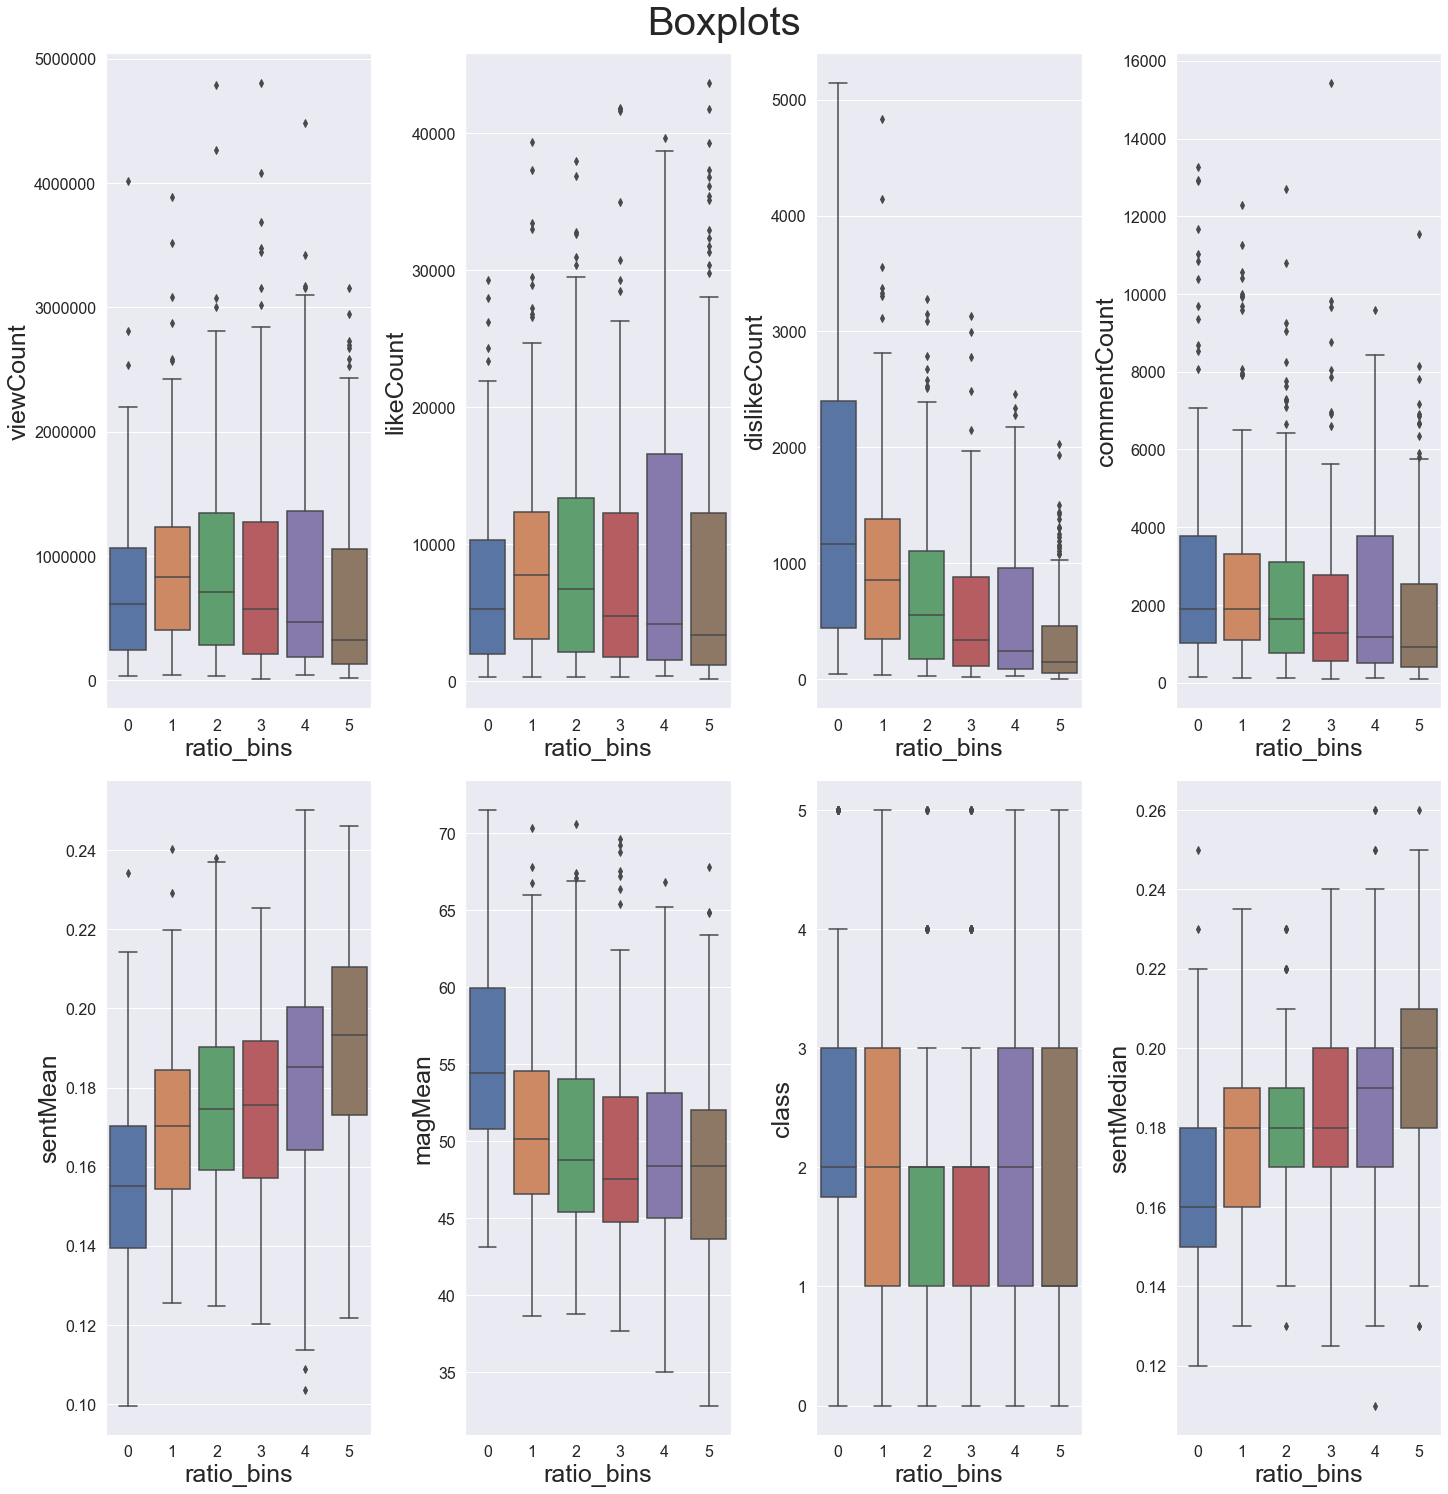

In [83]:
parameters = ['viewCount','likeCount','dislikeCount','commentCount','sentMean','magMean','class','sentMedian']
fig,axes = plt.subplots(2, 4, sharex=False, sharey=False,figsize = (20,20),constrained_layout=True)
plt.suptitle('Boxplots', size='40',y=1.03)
for i, ax in enumerate(axes.flat):
    sns.boxplot(x='ratio_bins',y=parameters[i],data=vids,ax=ax)
    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)
    ax.tick_params(labelsize=16)

We figured boxplots would be the best way to visualise all of our key parameters at once, compared with ratio_bins.  
Right off the bat, we can see that the view count is quite evently distributed with a fairly even amount of outliers, which is expected.  
It is interesting to see that category 4 has the highest number of likes, compared to the other categories which are all outliers. Conversely, category 0 has the highest number of dislikes, far more than any of the other categories.  

We can also see that low ratio videos have a higher magnitude. 

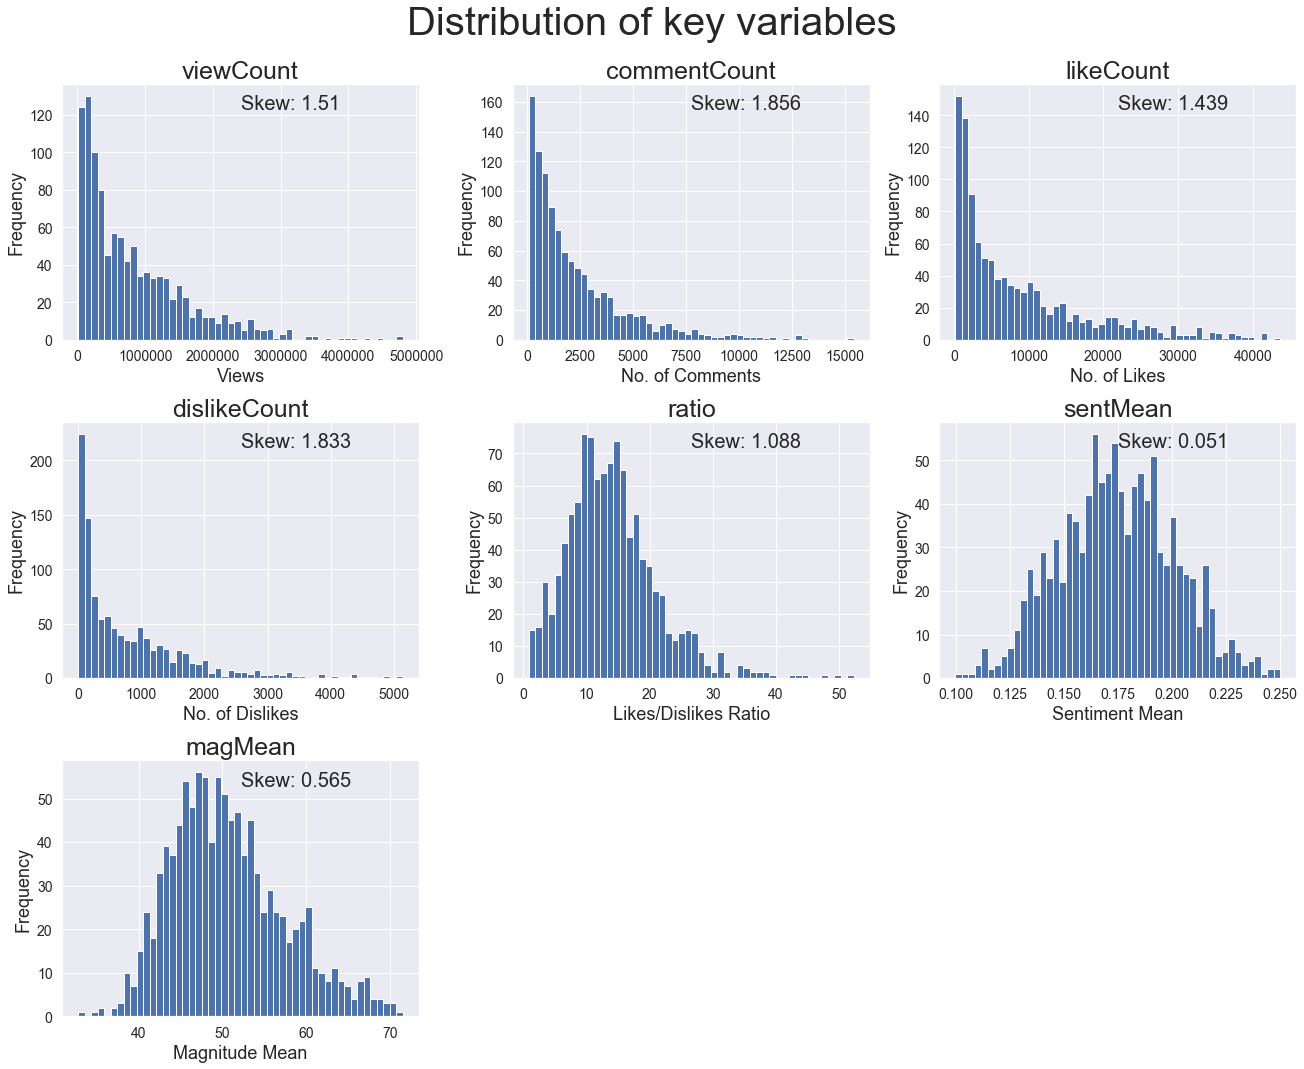

In [84]:
cols = ['viewCount','commentCount','likeCount',
              'dislikeCount','ratio','sentMean',
              'magMean']
x_label_list = ['Views','No. of Comments','No. of Likes','No. of Dislikes',
                'Likes/Dislikes Ratio','Sentiment Mean','Magnitude Mean']

fig,axes = plt.subplots(3, 3, sharex=False, sharey=False,figsize = (18,14),constrained_layout=True)
fig.suptitle('Distribution of key variables', size='40',y=1.05)
sns.set(font_scale=1)
#plt.tight_layout()
fig.delaxes(axes[2][2])
fig.delaxes(axes[2][1])


for i, ax in enumerate(axes.flat):
    if i > 6:
        break
    vids[cols[i]].hist(ax=ax,bins=50)
    skew = ('Skew: ' + str(round(vids[cols[i]].skew(),3)))
    ax.annotate(skew, xy = (0.5, 0.9), size = 20, xycoords = ax.transAxes)
    ax.set_title(cols[i], size=25)
    ax.set_xlabel(x_label_list[i], fontsize=18)
    ax.set_ylabel('Frequency', fontsize=18)
    ax.tick_params(labelsize=14)

something about how most of these histograms are skewed to the right, except for sentMean and magMean which obvs don't have much of skew

Text(0.5, 1, 'Ratio heatmap with key variables\n')

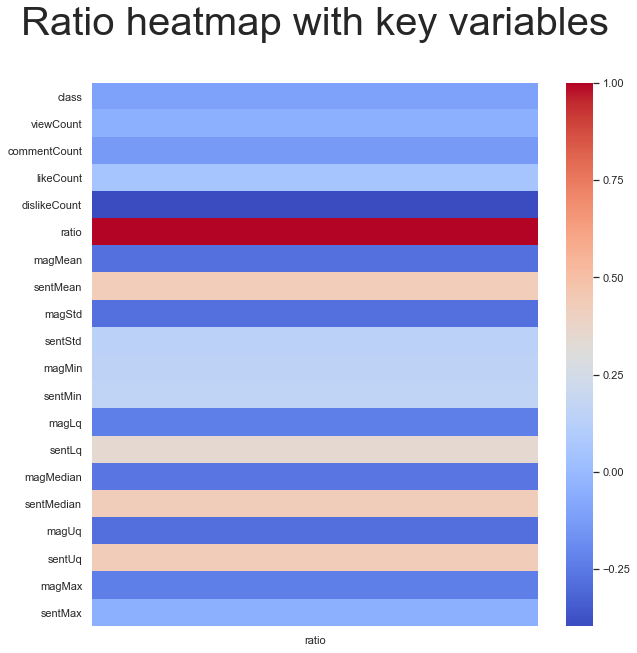

In [85]:
plt.figure(figsize=(10,10))
ratio_correlation = vids.corr().ratio
sns.heatmap(ratio_correlation.to_frame(),cmap = 'coolwarm')
plt.title('Ratio heatmap with key variables\n',size=40)

this heatmap is different to simon's one...

## Bivariate Analysis

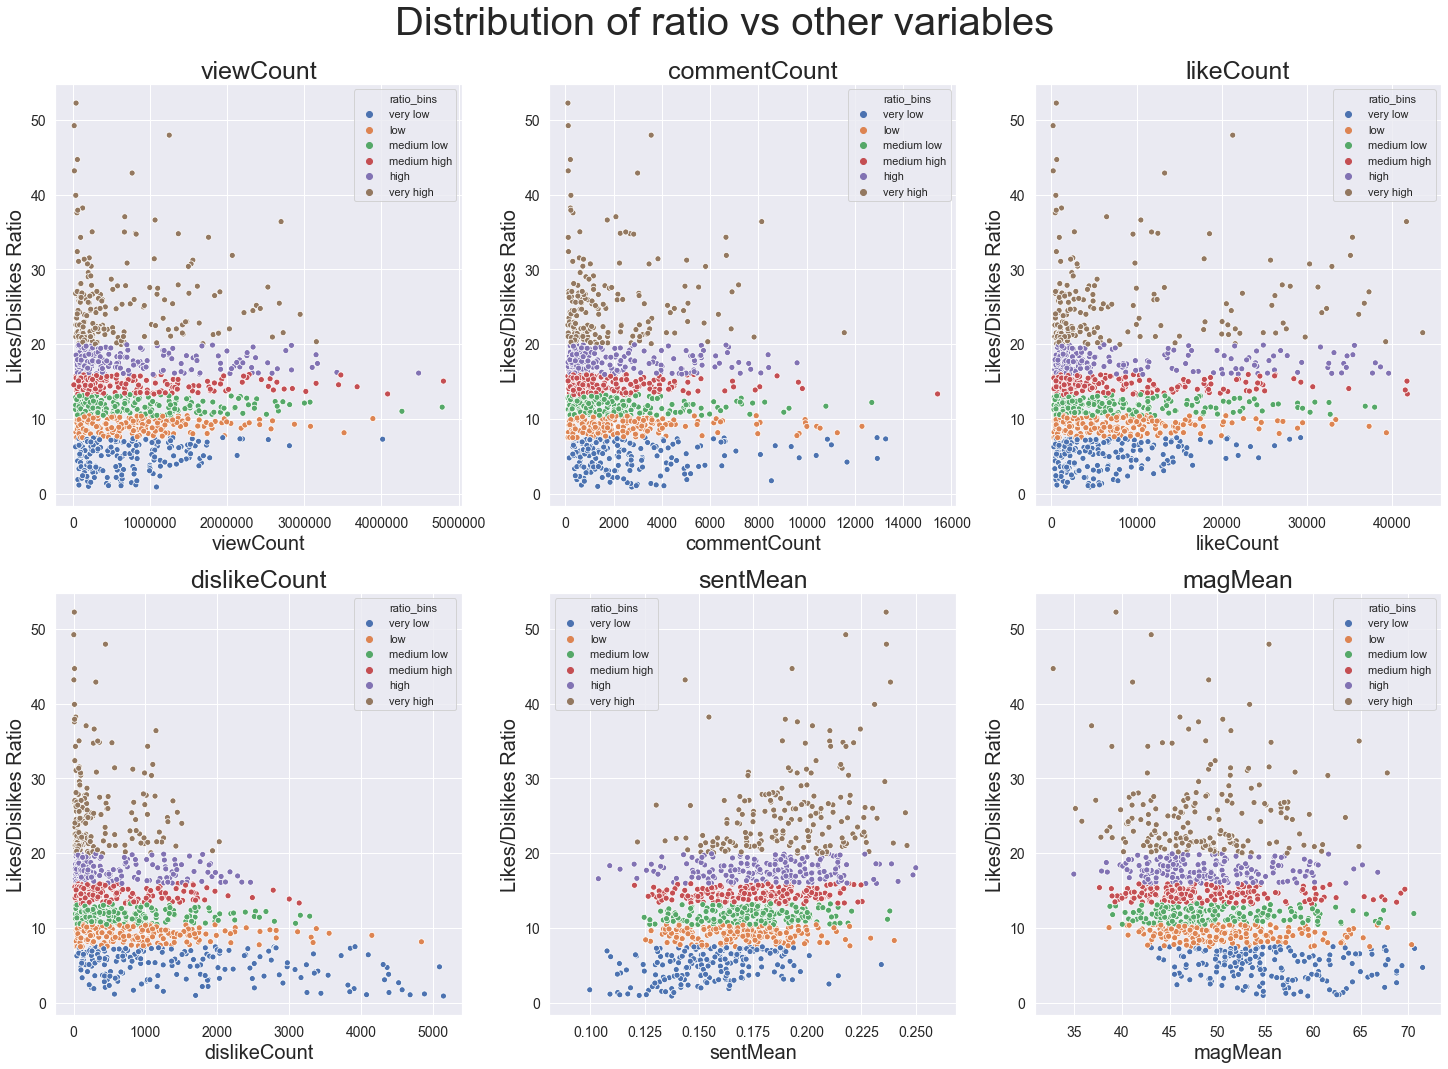

In [86]:
plotting_df = vids
bin_labels = ['very low','low','medium low','medium high','high','very high']
plotting_df['ratio_bins'] = pd.qcut(plotting_df['ratio'], q=6, labels = bin_labels)
#basic visualisation of ratio between sentiment and ratio
fig,axes = plt.subplots(2, 3, sharex=False, sharey=False,figsize = (20,14), constrained_layout=True)

cols = ['viewCount','commentCount','likeCount',
              'dislikeCount','sentMean','magMean']

fig.suptitle('Distribution of ratio vs other variables', size='40',y=1.05)
sns.set(font_scale=1)
#plt.tight_layout()


for i, ax in enumerate(axes.flat):
    sns.scatterplot(data=plotting_df, x=cols[i], y="ratio", hue='ratio_bins',ax=ax)
    ax.set_title(cols[i], size=25)
    ax.set_xlabel(cols[i],size=20)
    ax.set_ylabel('Likes/Dislikes Ratio',size=20)
    ax.tick_params(labelsize=14)

Text(0.5, 1.05, 'Pairgrid of key variables\n')

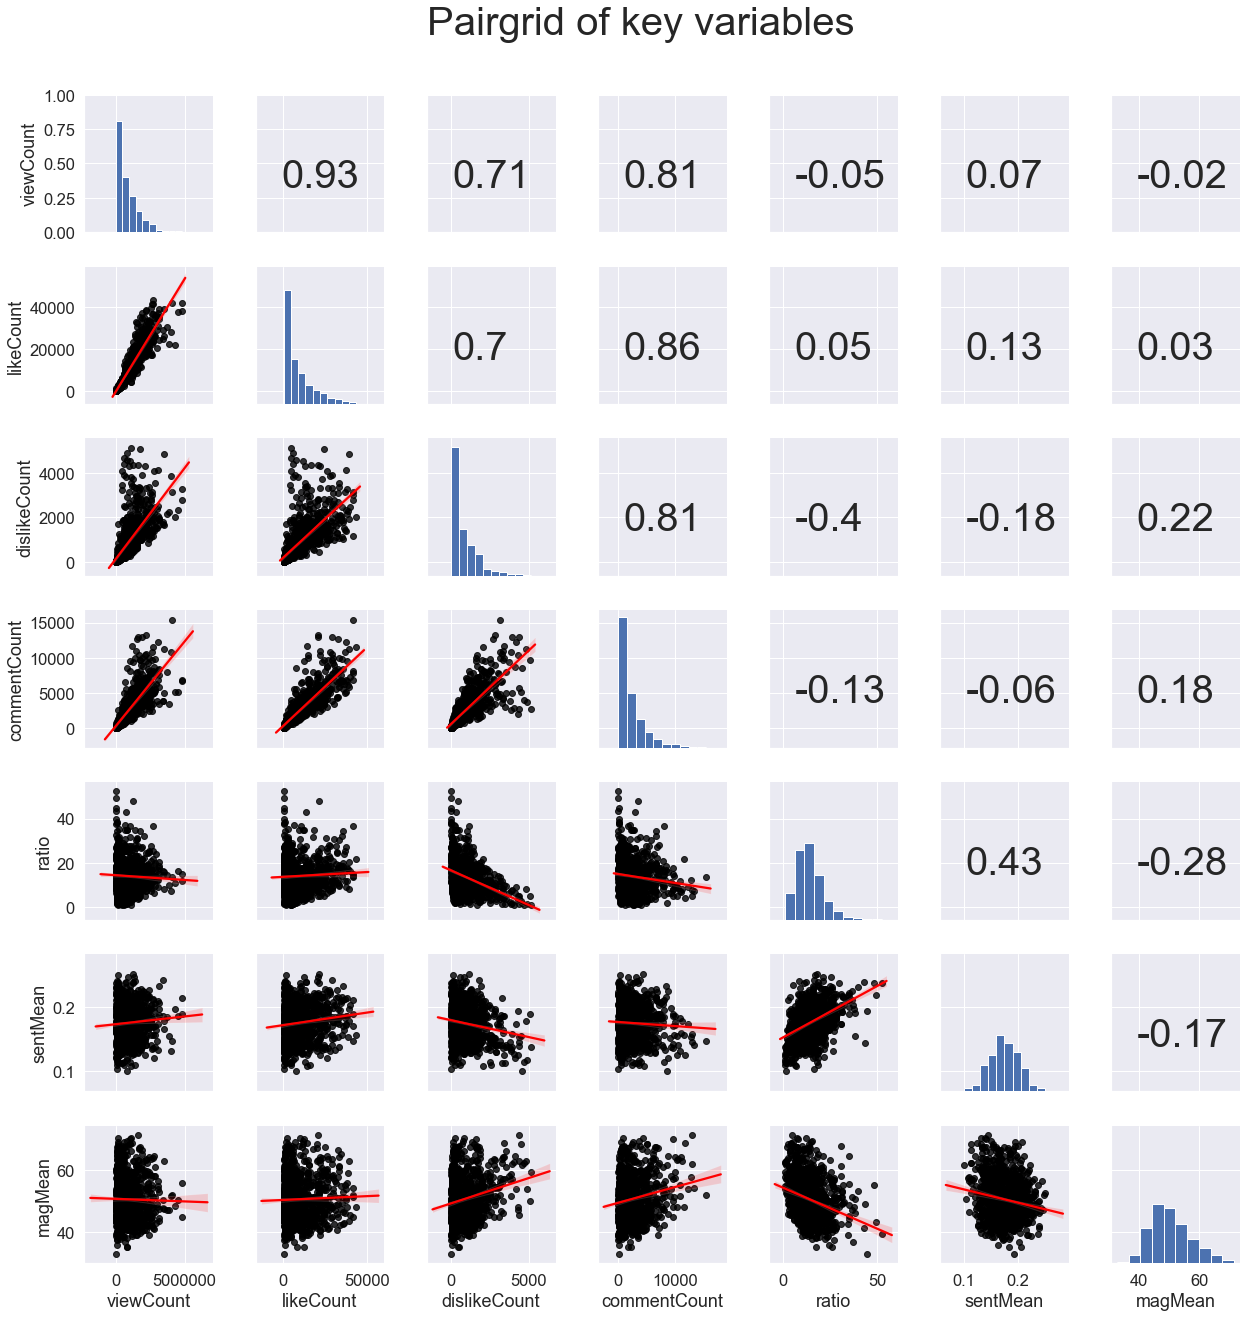

In [87]:
def corr(x, y, **kwargs):
    
    coef = np.corrcoef(x, y)[0][1]
    label = str(round(coef, 2))
    
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.33), size = 40, xycoords = ax.transAxes)
    
params = ['viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'ratio', 'sentMean', 'magMean']

sns.set(font_scale=1.5)
g = sns.PairGrid(vids[params])
g = g.map_lower(sns.regplot,line_kws={"color": "red"}, scatter_kws={'color':'black'})
g = g.map_diag(plt.hist)
g = g.map_upper(corr)
plt.suptitle('Pairgrid of key variables\n',size='40', y=1.05)

obvious correlation between:
    - viewCount and likeCount
    - viewCount and dislikeCount
    - viewCount and commentCount
    - likeCount and commentCount
    - dislikeCount and commentCount

um what else 

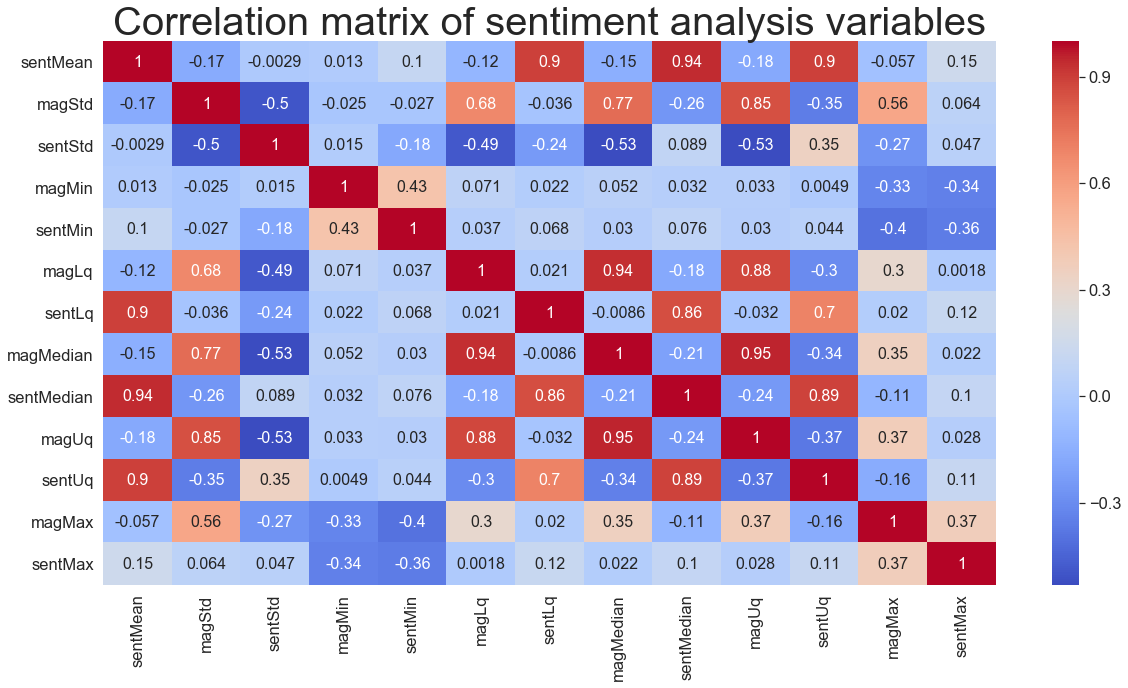

In [88]:
param = vids.columns[9:]
corr = vids[param]
plt.figure(figsize=(20, 10))
plt.title('Correlation matrix of sentiment analysis variables', size=40)
sns.heatmap(corr.corr(), cmap = 'coolwarm', annot = True, annot_kws = {"size":16})

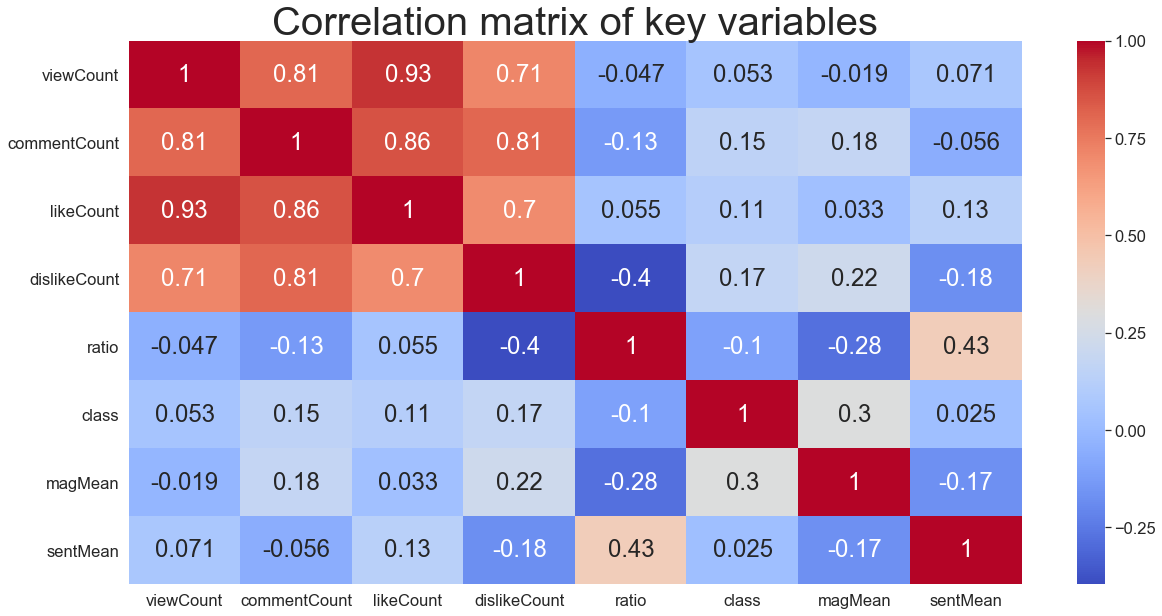

In [89]:
param = ['viewCount','commentCount','likeCount','dislikeCount','ratio','class','magMean','sentMean']
corr = vids[param]

plt.figure(figsize=(20, 10))
plt.title('Correlation matrix of key variables', size=40)

sns.heatmap(corr.corr(), cmap = 'coolwarm', annot = True, annot_kws = {"size":24})

Not much correlation of key variables except for commentCount, likeCount and dislikeCount, which all seem to be determined by viewCount.

# Data Analysis

## Basic Modelling

For our base modelling, we used linear regression for regression, and logistic regression for classification.  
Basic data preparation:

In [126]:
drop_parameters = ['date','title','ratio','ratio_bins','likeCount','dislikeCount']
X = vids.drop(drop_parameters,axis=1)
y = vids['ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

## Linear Regression

For our linear regression model, we used Linear Regression along with Recursive Feature Elimination for our prediction.

In [127]:
predictions = []
for i in range(1, 18):
    estimator = linear_model.LinearRegression()
    selector = RFE(estimator, i)
    selector.fit(X_train,y_train)
    predictions.append(selector.predict(X_test))

In [128]:
mse, rmse, rsquared, mae = ([] for i in range(4))
for prediction in predictions:
    mse.append(mean_squared_error(y_test, prediction))
    rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))
    rsquared.append(r2_score(y_test, prediction))
    mae.append(mean_absolute_error(y_test, prediction))
prediction_df = pd.DataFrame({'mse': mse, 'rmse': rmse, 'rsquared': rsquared, 'mae': mae})
prediction_df.index = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

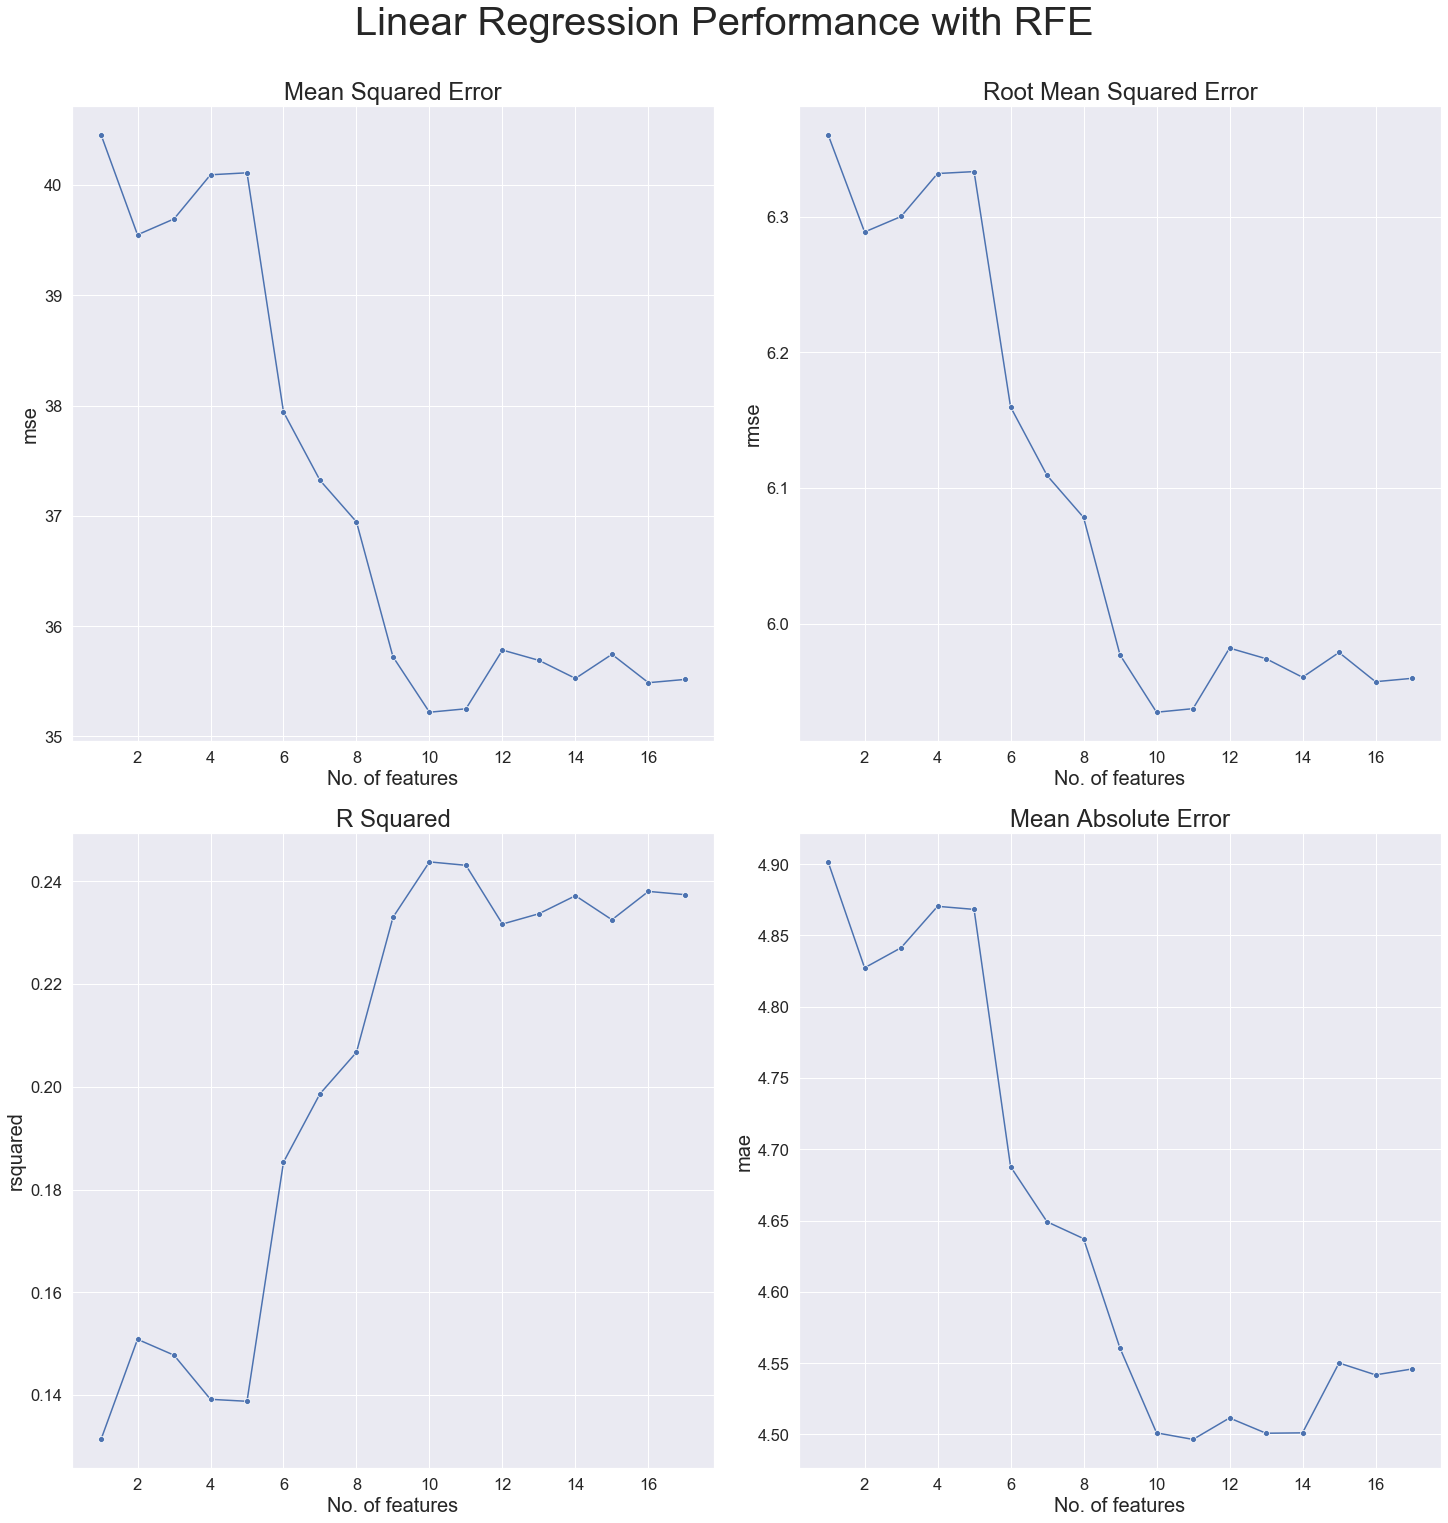

In [129]:
cols = ['mse','rmse','rsquared','mae']
titleList = ['Mean Squared Error','Root Mean Squared Error','R Squared','Mean Absolute Error']

fig,axes = plt.subplots(2, 2, sharex=False, sharey=False,figsize = (20,20),constrained_layout = True)
#plt.tight_layout()
fig.suptitle('Linear Regression Performance with RFE', size='40',y=1.05)
for i, ax in enumerate(axes.flat):
    sns.lineplot(data=prediction_df,x=prediction_df.index,y=cols[i],ax=ax,marker="o")
    ax.set_title(titleList[i],size='24')
    ax.set_xlabel('No. of features',size='20')
    ax.set_ylabel(cols[i],size='20')

In [130]:
drop_parameters = ['date','title','ratio','ratio_bins']
X = vids.drop(drop_parameters,axis=1)
y = vids['ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)
estimator = linear_model.LinearRegression()
selector = RFE(estimator,1)
selector.fit(X_train, y_train)
prediction = selector.predict(X_test)
feature_rankings = pd.DataFrame(
    {'features': X_train.columns,
     'ranking': selector.ranking_})
feature_rankings.sort_values(by=['ranking'])

,features,ranking
6,sentMean,1
8,sentStd,2
14,sentMedian,3
12,sentLq,4
16,sentUq,5
10,sentMin,6
18,sentMax,7
9,magMin,8
7,magStd,9
13,magMedian,10


We see that the linear regression performs the best with all of the features. We observe the ranking of importance of these features.

In [131]:
def regresults_dict1(prediction,string):
    foo = dict()
    foo['mse'] = mean_squared_error(y_test, prediction)
    foo['rmse'] = np.sqrt(mean_squared_error(y_test, prediction))
    foo['r2'] = r2_score(y_test, prediction)
    foo['mae'] = mean_absolute_error(y_test, prediction)
    foo['type'] = string
    return foo
reg_results1 = regresults_dict1(reg_prediction,'Linear regression')

## Logistic Regression

For our logistic regression model, we used Logistic Regression along with Recursive Feature Elimination again.

In [95]:
drop_parameters = ['date','title','ratio','ratio_bins','dislikeCount','likeCount']
X = vids.drop(drop_parameters,axis=1)
y = vids['ratio_bins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [96]:
predictions = []
for i in range(1, 18):
    estimator = LogisticRegression(solver='liblinear',multi_class='auto',random_state=42)
    selector = RFE(estimator, i)
    selector.fit(X_train,y_train)
    predictions.append(selector.predict(X_test))

In [97]:
accuracy, f1, recall, precision = ([] for i in range(4))
for prediction in predictions:
    accuracy.append(accuracy_score(y_test,prediction))
    f1.append(f1_score(y_test,prediction,average='macro'))
    recall.append(recall_score(y_test,prediction,average='macro'))
    precision.append(precision_score(y_test,prediction,average='macro'))
    
prediction_df = pd.DataFrame({'accuracy': accuracy,'f1': f1,'recall': recall,'precision': precision})

prediction_df.index = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

C:\Users\moste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


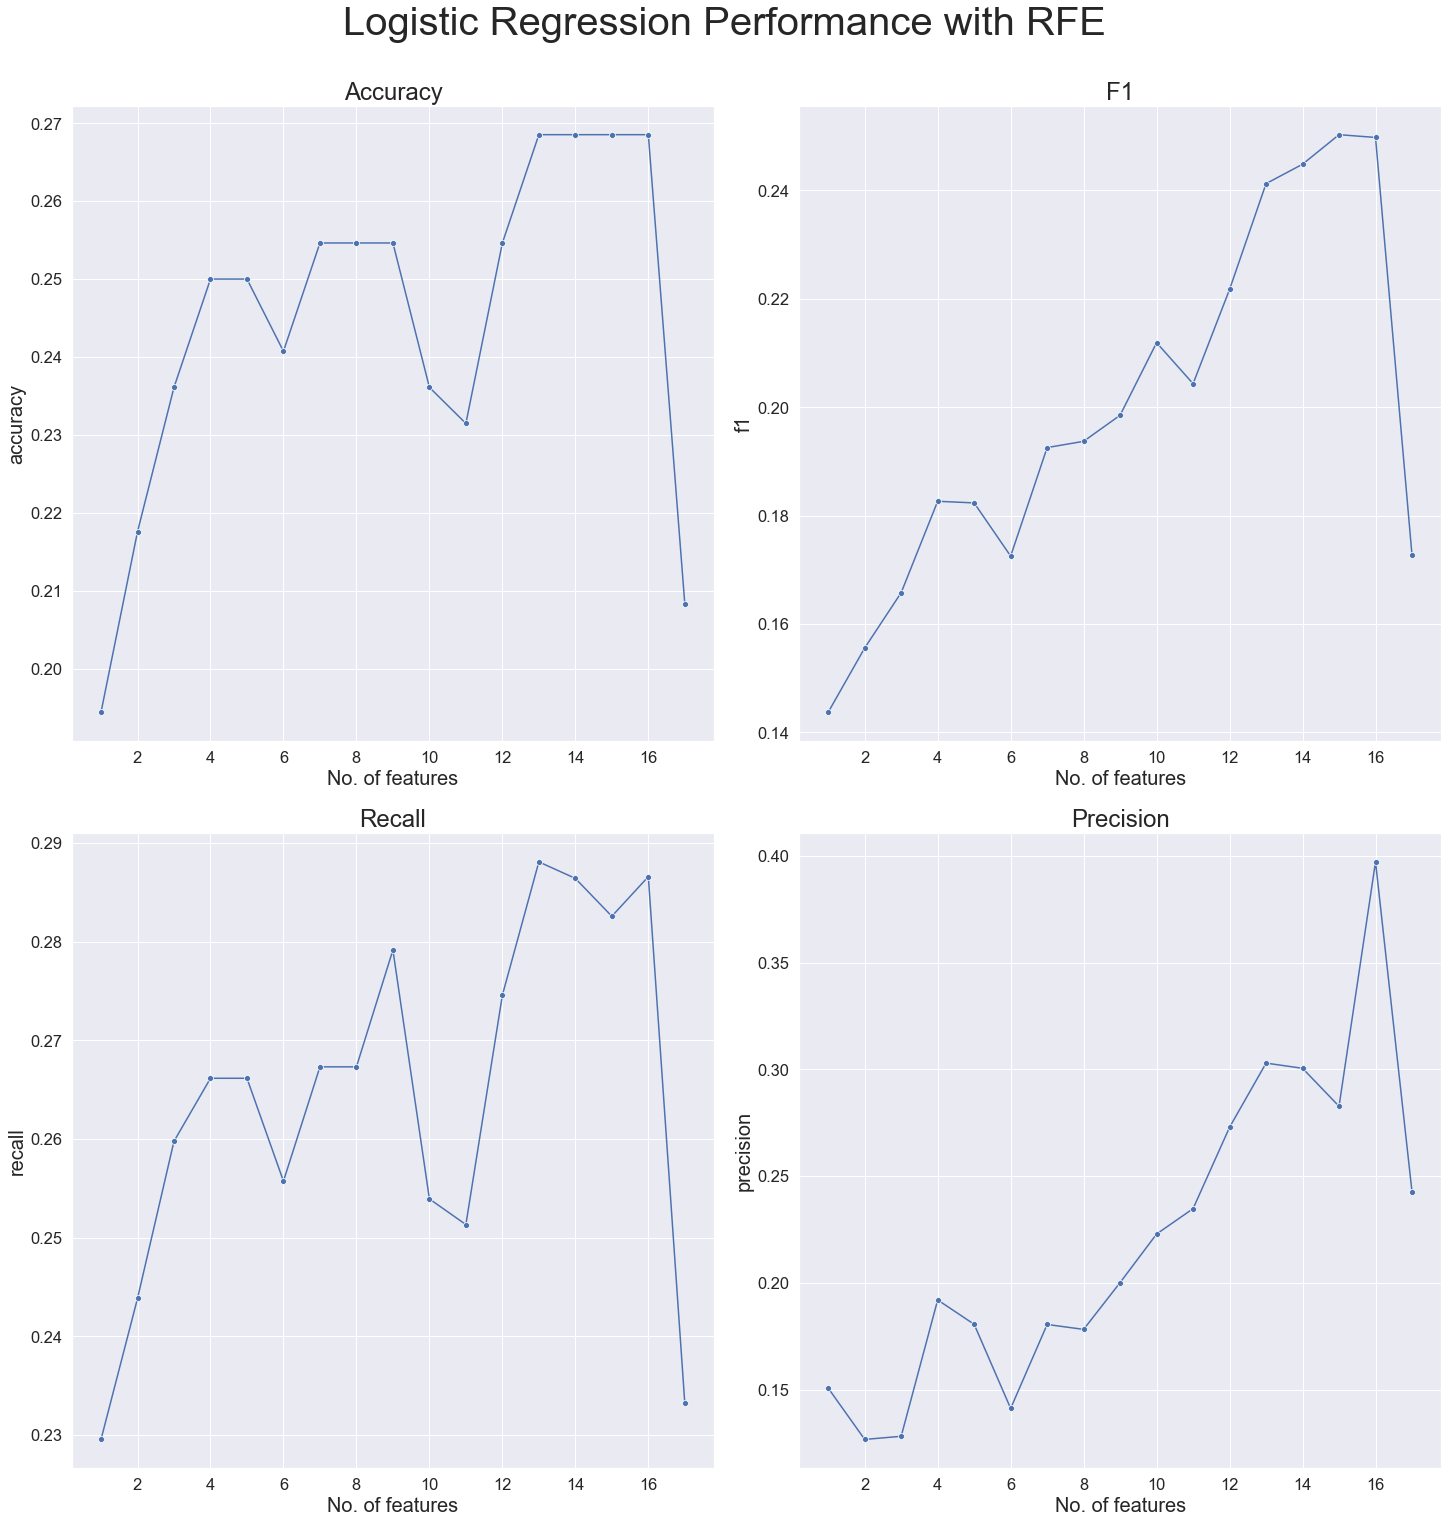

In [98]:
cols = ['accuracy','f1','recall','precision']
titleList = ['Accuracy','F1','Recall','Precision']

fig,axes = plt.subplots(2, 2, sharex=False, sharey=False,figsize = (20,20),constrained_layout = True)
#plt.tight_layout()
fig.suptitle('Logistic Regression Performance with RFE', size='40',y=1.05)
for i, ax in enumerate(axes.flat):
    sns.lineplot(data=prediction_df,x=prediction_df.index,y=cols[i],ax=ax,marker="o")
    ax.set_title(titleList[i],size='24')
    ax.set_xlabel('No. of features',size='20')
    ax.set_ylabel(cols[i],size='20')

In [99]:
estimator = LogisticRegression(multi_class='auto', solver='liblinear')
selector = RFE(estimator, 1)
selector.fit(X_train,y_train)

feature_rankings = pd.DataFrame(
    {'features': X_train.columns,
     'ranking': selector.ranking_})
feature_rankings.sort_values(by=['ranking'])

,features,ranking
14,sentUq,1
4,sentMean,2
12,sentMedian,3
8,sentMin,4
10,sentLq,5
16,sentMax,6
7,magMin,7
6,sentStd,8
9,magLq,9
3,magMean,10


# Improved Modelling

For our improved modelling, we used RandomForestRegressor for regression, and SVC, RandomForestClassifier and DecisionTree for classification. They were all run through GridSearchCV in order to find the best combination of parameters for the best training and testing result possible. 

## Linear Regression
### RandomForestRegressor

In [101]:
drop_parameters = ['date','title','ratio','ratio_bins','dislikeCount','likeCount']
X = vids.drop(drop_parameters,axis=1)
y = vids['ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
        param_grid={
            'max_depth': [9,7,5,3, None],
            'n_estimators': (100,200,400,600,800,1000),
            'max_features': (2,4,6,10,12,15,16,17),
            'min_samples_split': [2, 5, 10]
        }, cv=10, n_jobs=-1, scoring='r2')
grid_search = grid_search.fit(X_train, y_train)

Dropping parameters that would dilute the result of the training/testing.

In [102]:
grid_search = load('files/joblibs/randomforestregressor.joblib')

In [103]:
feature_rankings = grid_search.best_estimator_.feature_importances_
feature_rankings = pd.DataFrame(
    {'features': X_train.columns,
     'ranking': feature_rankings})
feature_rankings.sort_values(by=['ranking'],  ascending=False)

,features,ranking
10,sentLq,0.105902
14,sentUq,0.080515
15,magMax,0.073078
4,sentMean,0.072592
2,commentCount,0.072034
9,magLq,0.069626
13,magUq,0.062922
3,magMean,0.061485
8,sentMin,0.060520
1,viewCount,0.059844


In [104]:
rfr = grid_search.best_estimator_
rfr.fit(X_train, y_train)
rfr_prediction = rfr.predict(X_test)

In [105]:
reg = linear_model.LinearRegression().fit(X_train, y_train)
reg_prediction = reg.predict(X_test)

In [106]:
def regresults_dict(prediction,string):
    foo = dict()
    foo['mse'] = mean_squared_error(y_test, prediction)
    foo['rmse'] = np.sqrt(mean_squared_error(y_test, prediction))
    foo['r2'] = r2_score(y_test, prediction)
    foo['mae'] = mean_absolute_error(y_test, prediction)
    foo['type'] = string
    return foo
reg_results = regresults_dict(reg_prediction,'Linear regression')
rfr_results = regresults_dict(rfr_prediction, 'Random forest regression')


In [188]:
rfr_frame = pd.DataFrame([rfr_results])
lin_frame = pd.DataFrame([reg_results])
regression_performance = rfr_frame.append(lin_frame)
print('Key performance comparison of random forest regression and linear regression')
regression_performance

Key performance comparison of random forest regression and linear regression


,mae,mse,r2,rmse,type
0,4.077649,31.381324,0.326195,5.601904,Random forest regression
0,4.545929,35.516986,0.237396,5.959613,Linear regression


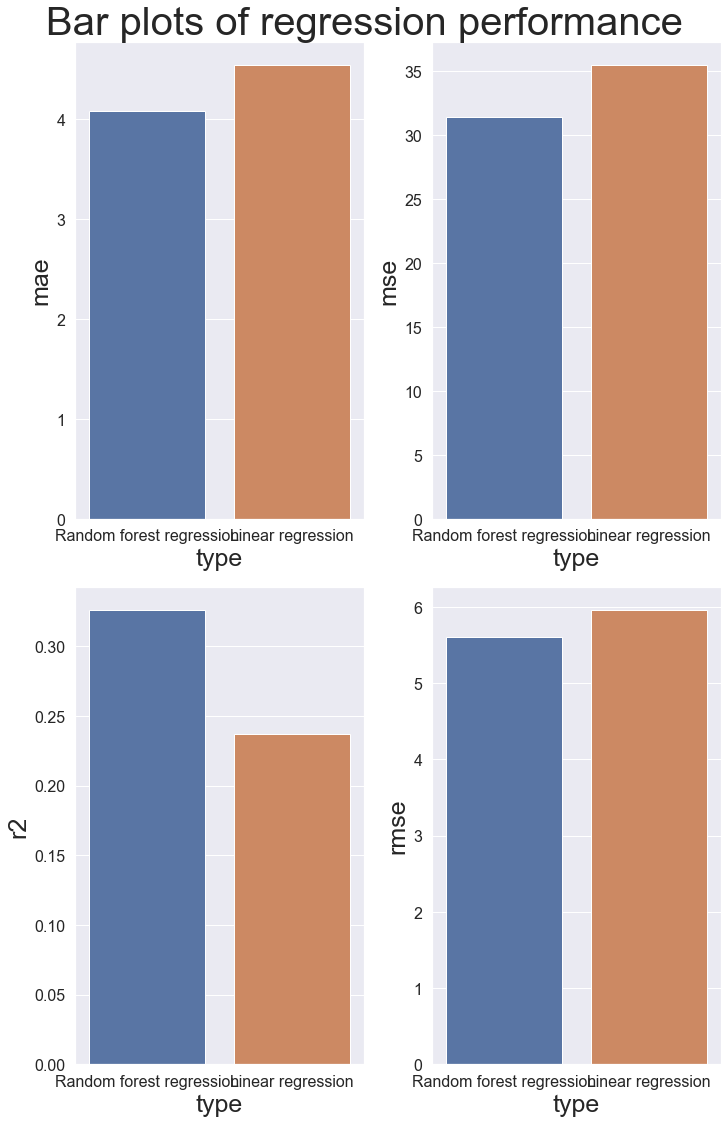

In [108]:
cols = regression_performance.columns[:4]
fig,axes = plt.subplots(2, 2, sharex=False, sharey=False,figsize = (10,15),constrained_layout=True)
plt.suptitle('Bar plots of regression performance', size='40',y=1.03)
for i, ax in enumerate(axes.flat):
    sns.barplot(x='type',y=cols[i],data=regression_performance,ax=ax)
    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)
    ax.tick_params(labelsize=16)

## Classification
### DecisionTreeClassifier, RandomForestClassifier and GridSearchCV

In [109]:
drop_parameters = ['date','title','ratio','ratio_bins','dislikeCount','likeCount']
X = vids.drop(drop_parameters,axis=1)
y = vids['ratio_bins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [110]:
models = [DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42)]
params = [dict(criterion=['gini','entropy'],splitter=['best','random'],max_depth=[None,3,5,6],max_features=[None,2,4,6,8,10,12,14,15,16,17]),
          dict(min_samples_leaf=[50,1],n_estimators=[50,100,500],max_features=[None,2,4,6,8,10,12,14,15,16,17])]

grid_searches = []

for model,param in zip(models,params):
    grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_searches.append(grid_search.fit(X_train,y_train))

Fitting 10 folds for each of 176 candidates, totalling 1760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1760 out of 1760 | elapsed:    5.5s finished
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 66 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  1.4min finished
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [111]:
grid_searches = []
grid_searches.append(load('files/joblibs/randomforestclassifierNEW.joblib'))
grid_searches.append(load('files/joblibs/decisiontreeclassifier.joblib'))

rankings = []
for i in range(len(grid_searches)):
    clf = grid_searches[i].best_estimator_
    rankings.append(clf.feature_importances_)

In [112]:
for i,ranking in enumerate(rankings):
    feature_rankings = grid_searches[i].best_estimator_.feature_importances_
    feature_rankings = pd.DataFrame(
        {'features': X_train.columns,
         'ranking': feature_rankings})
    print("\n",feature_rankings.sort_values(by=['ranking'],  ascending=False))


         features   ranking
10        sentLq  0.109076
15        magMax  0.101386
14        sentUq  0.099759
6        sentStd  0.086632
2   commentCount  0.074951
9          magLq  0.074431
3        magMean  0.070868
4       sentMean  0.058171
13         magUq  0.058122
8        sentMin  0.056238
7         magMin  0.055513
1      viewCount  0.045448
11     magMedian  0.034514
12    sentMedian  0.021929
5         magStd  0.021484
16       sentMax  0.016339
0          class  0.015137

         features   ranking
14        sentUq  0.252339
1      viewCount  0.095024
8        sentMin  0.090020
0          class  0.082269
6        sentStd  0.075455
2   commentCount  0.072041
10        sentLq  0.068179
9          magLq  0.066759
7         magMin  0.054387
15        magMax  0.035842
3        magMean  0.030363
11     magMedian  0.021898
13         magUq  0.021657
4       sentMean  0.017687
12    sentMedian  0.016079
5         magStd  0.000000
16       sentMax  0.000000


In [113]:
estimator = LogisticRegression(solver='liblinear',multi_class='auto',random_state=42)
selector = RFE(estimator, 14)
selector.fit(X_train,y_train)
logistic_prediction = selector.predict(X_test)

In [114]:
decision_tree = grid_searches[0].best_estimator_
decision_tree.fit(X_train,y_train)
tree_prediction = decision_tree.predict(X_test)

In [115]:
rfc = grid_searches[1].best_estimator_
rfc.fit(X_train,y_train)
forest_prediction = rfc.predict(X_test)

In [116]:
def results_dict(prediction,string):
    foo = dict()
    foo['accuracy'] = accuracy_score(y_test,prediction)
    foo['f1'] = f1_score(y_test,prediction,average='macro')
    foo['recall'] = recall_score(y_test,prediction,average='macro')
    foo['precision'] = precision_score(y_test,prediction,average='macro')
    foo['type'] = string
    return foo

In [117]:
log_results = results_dict(logistic_prediction,'Logistic')
tree_results = results_dict(tree_prediction,'Decision')
forest_results = results_dict(forest_prediction,'Forest')

In [118]:
log_frame = pd.DataFrame([log_results])
tree_frame = pd.DataFrame([tree_results])
forest_frame = pd.DataFrame([forest_results])
classification_performance = log_frame.append(tree_frame).append(forest_frame)
print('Key performance comparison of classifiers')
regression_performance

Key performance comparison of classifiers


,mae,mse,r2,rmse,type
0,4.077649,31.381324,0.326195,5.601904,Random forest regression
0,4.545929,35.516986,0.237396,5.959613,Linear regression


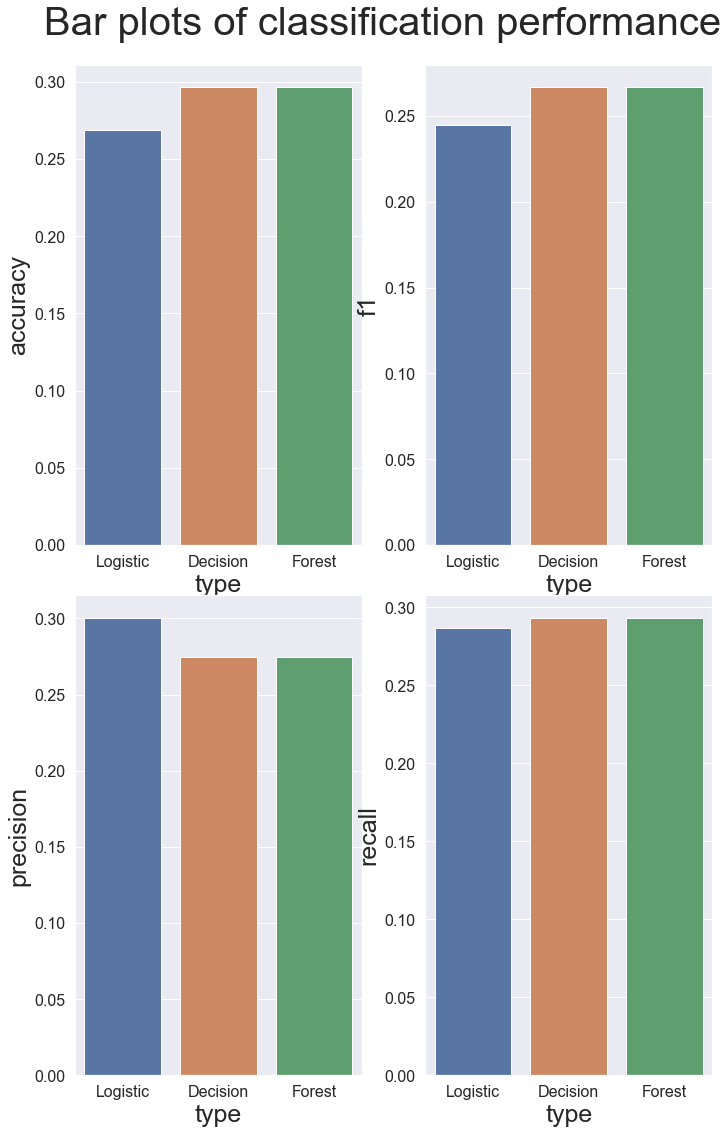

In [119]:
cols = classification_performance.columns[:4]
fig,axes = plt.subplots(2, 2, sharex=False, sharey=False,figsize = (10,15))
plt.suptitle('Bar plots of classification performance', size='40',y=1.03)
plt.tight_layout()
for i, ax in enumerate(axes.flat):
    sns.barplot(x='type',y=cols[i],data=classification_performance,ax=ax)
    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)
    ax.tick_params(labelsize=16)


## Improved Models Compared to Basic Models

### Basic Modelling
#### Linear regression with RFE:  
**MSE**: 35.22  
**MSE sqrt**: 5.93  
**R2**: 0.24  
**MAE**: 4.5  
  
#### Logistic regression with RFE:  
**Accuracy**: 0.269  
**F1**: 0.25  
**R2**: 0.288  
**Precision**: 0.397  
### Improved Modelling  
#### Linear regression with RandomForestRegressor:  
**MSE**: 29.533  
**MSE sqrt**: 5.4345  
**R2**: 0.382  
**MAE**: 4.0377  
#### DecisionTreeClassifier with GridSearchCV: (i think?)  
**Accuracy**:  0.336  
**F1**:  0.3146  
**Precision**:  0.328  
**Recall**:  0.331  
#### RandomForestClassifier with GridSearchCV: (i think?)  
**Accuracy**:  0.350  
**F1**:  0.290  
**Precision**:  0.3428  
**Recall**:  0.325  

In [201]:
raw_data = {'stuff': ['MSE', 'MSE sqrt', 'R2', 'MAE'],
        'before': [35.22, 5.93, 0.24, 4.5],
        'after': [29.533, 5.4345, 0.382, 4.0377]}
df = pd.DataFrame(raw_data, columns = ['stuff', 'before', 'after'])
df

,stuff,before,after
0,MSE,35.22,29.5330
1,MSE sqrt,5.93,5.4345
2,R2,0.24,0.3820
3,MAE,4.50,4.0377


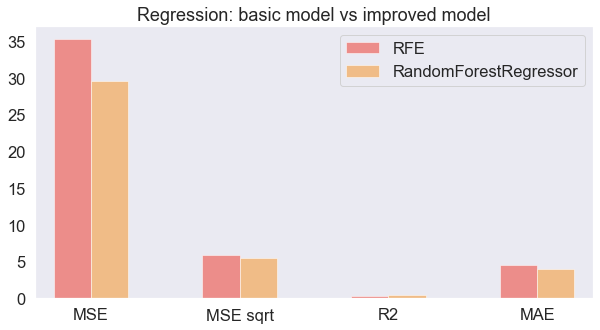

In [216]:
pos = list(range(len(df['before']))) 
width = 0.25 

fig, ax = plt.subplots(figsize=(10,5))

plt.bar(pos, 
        df['before'], 
        width, 
        alpha=0.5, 
        color='#EE3224', 
        label=df['stuff'][0]) 


plt.bar([p + width for p in pos], 
        df['after'],
        width, 
        alpha=0.5, 
        color='#F78F1E', 
        label=df['stuff'][1]) 

ax.set_ylabel('')
ax.set_title('Regression: basic model vs improved model')
ax.set_xticks([p + 0.5 * width for p in pos])
ax.set_xticklabels(df['stuff'])
plt.xlim(min(pos)-width, max(pos)+width*2)
plt.ylim(0)
plt.legend(['RFE', 'RandomForestRegressor'], loc='upper right')
plt.grid()
plt.show()

Above is the model for basic regression using RecursiveFeatureElimination vs improved model regression using RandomForestRegressor. In this graph, lower is better. We can see that the MSE is a lot lower when using RFR. The other values did not change that much.

In [217]:
raw_data = {'stuff': ['Accuracy', 'F1', 'Precision', 'Recall'],
        'before': [0.269, 0.25, 0.397, 0],
        'after': [0.336, 0.3146, 0.328, 0.331], 
        'after_after': [0.350, 0.290, 0.3428, 0.325]}
df = pd.DataFrame(raw_data, columns = ['stuff', 'before', 'after', 'after_after'])
df

,stuff,before,after,after_after
0,Accuracy,0.269,0.3360,0.3500
1,F1,0.250,0.3146,0.2900
2,Precision,0.397,0.3280,0.3428
3,Recall,0.000,0.3310,0.3250


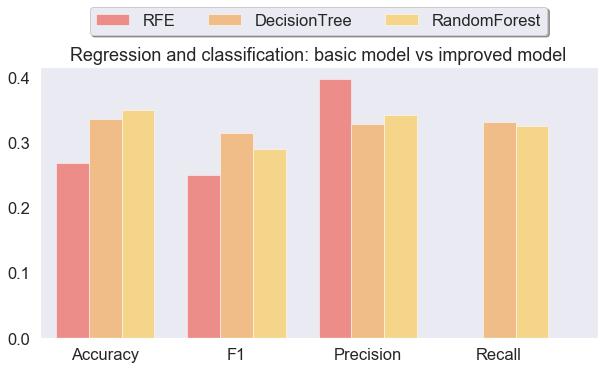

In [223]:
pos = list(range(len(df['before']))) 
width = 0.25 

fig, ax = plt.subplots(figsize=(10,5))

plt.bar(pos, 
        df['before'], 
        width, 
        alpha=0.5, 
        color='#EE3224', 
        label=df['stuff'][0]) 


plt.bar([p + width for p in pos], 
        df['after'],
        width, 
        alpha=0.5, 
        color='#F78F1E', 
        label=df['stuff'][1]) 

plt.bar([p + width*2 for p in pos], 
        df['after_after'], 
        width, 
        alpha=0.5, 
        color='#FFC222', 
        label=df['stuff'][2]) 

ax.set_ylabel('')
ax.set_title('Regression and classification: basic model vs improved model')
ax.set_xticks([p + width for p in pos])
ax.set_xticklabels(df['stuff'])
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim(0)
plt.legend(['RFE', 'DecisionTree', 'RandomForest'], loc='upper center', bbox_to_anchor=(0.5, 1.25),
    ncol=3, fancybox=True, shadow=True)
plt.grid()
plt.show()

Above is the model for logistic regression using RecursiveFeatureElimination vs improved models using DecisionTreeClassifier and RandomForestClassifier. In this graph, a higher value is better.  

RandomForest was the most accurate, but failed to top F1, Precision and Recall.

# Summary and Future Improvement

# Conclusion